In [1]:
import sys
sys.path.append("..")
import os, pickle, scipy
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle as pkl
from tqdm import tqdm_notebook as tqdm
from coh_tools import *
%matplotlib inline

/home/julien/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
os.chdir("/mnt/hdd2tb/lab/elife/data")
# os.chdir(r"C:\Users\julienb\lab\data")

In [3]:
experiments = pd.read_csv('table_of_experiments.csv')

In [4]:
stim_experiments = experiments #.loc[experiments["stim_Coh_from"] != 0]

In [5]:
stim_experiments.head()

Experiment   Monkey  YYYYMMDD   Session PREAMP  \
0  Experiment1  MonkeyG  20150908  Session2     M1   
1  Experiment2  MonkeyG  20150908  Session3     M1   
2  Experiment3  MonkeyG  20150908  Session4     M1   
3  Experiment4  MonkeyG  20150909  Session2     M1   
4  Experiment5  MonkeyG  20150909  Session3     M1   

                          File Name  stim_Coh_from  stim_Coh_to  \
0  MonkeyG_20150908_Session2_M1.zip             46           63   
1  MonkeyG_20150908_Session3_M1.zip             48           43   
2  MonkeyG_20150908_Session4_M1.zip             48           16   
3  MonkeyG_20150909_Session2_M1.zip             48           12   
4  MonkeyG_20150909_Session3_M1.zip             53           27   

   Number of Lasers in Experiment  Number of Lasers during Conditioning Delay  \
0                               2                                     2  10ms   
1                               2                                     2  10ms   
2                               2                                     2  10ms   
3                               2                                     2  10ms   
4                               2                                     2  10ms   

                                            m1_sites  \
0  1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,1...   
1  1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,1...   
2  1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,1...   
3  1,3,5,7,9,11,13,15,17,19,21,23,25,27,29,31,2,4...   
4  1,3,5,7,9,11,13,15,17,19,21,23,25,27,29,31,2,4...   

                                            s1_sites  
0  50,52,54,56,57,58,59,60,61,62,63,64,65,66,67,6...  
1  50,52,54,56,57,58,59,60,61,62,63,64,65,66,67,6...  
2  50,52,54,56,57,58,59,60,61,62,63,64,65,66,67,6...  
3  10,33,34,35,36,37,54,56,57,58,59,60,61,62,63,6...  
4  10,33,34,35,36,37,54,56,57,58,59,60,61,62,63,6...

In [6]:
stim_experiments_list = stim_experiments["File Name"].tolist()
stim_experiments_list = [name[:-4] for name in stim_experiments_list]

In [7]:
# data, sample_freq = extract_lfp(r"C:\Users\julienb\lab\data\MonkeyG_20150908_Session3_M1\RecordingBlocks\RecBlock1.mat", True)

In [8]:
# # Function that takes in data matrix and returns matrix of coherences for 20 second partitions
# # using windows of 2 seconds each, and discarding remainder of 2 seconds
# def timefreq_coherence(signals, sample_frequency, partition_seconds=20, want_f=False):
#     num_partitions = int((signals.shape[1] / sample_frequency // partition_seconds) * 2 - 1)
#     Nwin = int(partition_seconds * sample_frequency // 10) # int(round(10 * sample_frequency))
#     nperseg = Nwin #?
#     nfft = nextpow2(Nwin) #16384
#     ovlp = int(Nwin/2)
#     timefreq_mm = []
# #     print(nperseg)
# #     print(Nwin)
# #     print(nfft)
# #     print(ovlp)
# #     print(num_partitions)
#     for partition_i in range(num_partitions):
#         partition = signals[:,partition_i*(int(sample_frequency)):(partition_i+1)*(int(sample_frequency))]
        
#         mm = np.zeros((96, 96, 1025)) #1025 is hardcoded and should be a function
#         for from_index in range(96):
#             for to_index in range(from_index+1, 96):
#                 c = coh(signals[from_index,:], signals[to_index,:], sample_frequency, 
#                     hamming(Nwin), nperseg=nperseg, nfft=nfft, noverlap=ovlp)
#                 mm[from_index,to_index] = c[1]
#                 mm[to_index, from_index] = c[1]
#         mm += np.dstack([np.identity(96)]*1025)
#         timefreq_mm.append(mm)
        
#     timefreq_mm = np.array(timefreq_mm)
#     if want_f:
#             return (timefreq_mm, c[0])   
#     return timefreq_mm

In [9]:
# test = timefreq_coherence(data, sample_freq)

In [10]:
# test.shape

## Structure of coherence data:
One dictionary for each session. Keywords are rec1, stim1, etc., and each contain data as [times, 96, 96, freqs]

In [11]:
for experiment_i in tqdm(range(len(stim_experiments_list))): 
    
    
    session_data_dict = {}
    
    experiment = stim_experiments_list[experiment_i]
    file_location = experiment + "/RecordingBlocks/"
    first = True
    file_list = os.listdir(file_location)
    file_list.sort()
    stim_index = 1

    for filename in file_list:

        if not filename.endswith(".mat"):
            continue
        baseline_filename = file_location + filename
        savenamebase = experiment[:-3] + filename[:-4]

        data, sample_freq = extract_lfp(baseline_filename, True)

        all_band_coherences, freqs = timefreq_coherence(data, sample_freq, want_phase=True, want_f=True)
        session_data_dict[baseline_filename.split('/')[-1][0:-4]] = all_band_coherences[:,:,:,:403]
        
        if not first:
            stim_filename = baseline_filename.replace("Recording", "Conditioning").\
                replace("RecBlock"+str(stim_index+1), "CondBlock"+str(stim_index))
            stim_data = extract_lfp(stim_filename)
            all_stim_coh = timefreq_coherence(stim_data, sample_freq, want_phase=True)
            session_data_dict[stim_filename.split('/')[-1][0:-4]] = all_stim_coh[:,:,:,:403]

            stim_index += 1

        first = False
#     print(freqs[0])
#     print(freqs[-1])
#     pkl.dump(session_data_dict, open("../pickled/test", "wb"))
    pkl.dump(session_data_dict,open("/mnt/m1tb/20sec_allsession_phase/"+experiment, 'wb'))


In [12]:
session_data_dict['RecBlock1'].shape

(15, 96, 96, 403)

In [13]:
get_freq_band_indices(freqs, 0, 200)

[1, 403]

In [14]:
freqs[403]

200.17226537068683

In [15]:
sample_freq

1017.2526041666666

In [16]:
session_data_dict.keys()

dict_keys(['RecBlock1', 'RecBlock2', 'CondBlock1', 'RecBlock3', 'CondBlock2', 'RecBlock4', 'CondBlock3', 'RecBlock5', 'CondBlock4', 'RecBlock6', 'CondBlock5'])

In [17]:
session_data_dict['CondBlock5'].shape

(30, 96, 96, 403)

(array([  2.,   0.,   2.,   3.,  10., 133., 243.,   5.,   2.,   3.]),
 array([-3.14159265, -2.6263484 , -2.11110415, -1.5958599 , -1.08061565,
        -0.56537139, -0.05012714,  0.46511711,  0.98036136,  1.49560561,
         2.01084986]),
 <a list of 10 Patch objects>)

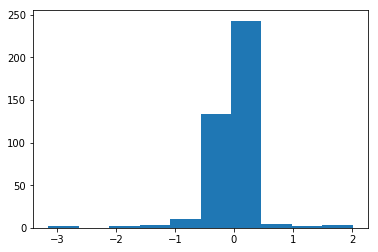

In [18]:
plt.hist(session_data_dict['RecBlock5'][0,3,0,:])

In [20]:
pkl.dump(freqs[:403],open("/mnt/m1tb/20sec_allsession_phase/freqs.pkl", 'wb'))


In [22]:
session_data_dict['CondBlock5'][0,3,0,:]

array([-3.14159265e+00,  1.73573937e+00,  1.96509758e+00,  1.89849685e+00,
        1.03529566e+00,  1.06809898e+00,  2.35235721e-01, -1.14874856e+00,
       -8.28266410e-02, -6.92342945e-01, -2.19188290e-01,  6.28031528e-01,
       -1.45221746e+00,  2.64966146e-01,  1.49449950e-01,  1.37606852e-02,
        8.17901768e-01,  1.59674566e-01, -2.94094713e-01,  7.99919300e-01,
        3.01530081e-01,  6.44131577e-01,  1.24880395e+00,  3.78637949e-01,
        1.18763418e+00,  1.27563889e+00,  5.80291696e-01, -5.29591584e-01,
       -1.64952038e-01, -3.73313344e-01,  1.26182372e-01,  1.74356214e-01,
        4.63097235e-01,  9.59229814e-01,  1.73885618e-01, -2.27399797e-01,
       -1.28587354e-01,  9.25205286e-02,  1.71070552e+00, -2.30361875e-01,
       -4.31614233e-01, -6.30052173e-01, -5.57823402e-01, -2.74915687e-01,
        1.26083873e-01,  8.95611703e-01,  3.88238452e-01,  5.16762425e-03,
        8.13986161e-03, -3.34042801e-04,  7.14024925e-02,  3.44214480e-02,
        4.19642461e-02,  